# An efficient implementation of the Sinkhorn algorithm for the GPU
*Thomas Viehmann <tv@mathinf.eu>*

Recently the Wasserstein distance has seen new applications in machine learning and deep learning. It commonly replaces the Kullback-Leibler divergence (also often dubbed cross-entropy loss in the Deep Learning context). In contrast to the latter, Wasserstein distances not only consider the values probability distribution or density at any given point, but also incorporating spatial information in terms of the underlying metric regarding these differences. Intuitively, it yields a smaller distance if probability mass moved to a nearby point or region and a larger distance if probability mass moved far away.

There are two predominant variants of Wasserstein distance approximations used in machine learning:
- Stochastically optimised online estimates of the Wasserstein distance. This is the concept underpinning many of the GAN applications using a (heuristic approximation of) the Wasserstein distance as a *discriminator*. Starting from the [Wasserstein GAN](https://arxiv.org/abs/1701.07875) as an improvement over the KL-based DCGAN, with improvements to how to estimate the Wasserstein distance in [WGAN-GP](https://arxiv.org/abs/1704.00028), and [SN-GAN](https://openreview.net/forum?id=B1QRgziT-).
- Direct computation of the Wasserstein distance as a replacement for the cross-entropy loss in mini-batch training. This is commonly done using the entropy regularised Wasserstein distance and the Sinkhorn iterations [Cuturi](https://papers.nips.cc/paper/4927-sinkhorn-distances-lightspeed-computation-of-optimal-transport). In the context of deep learning this has been proposed by [Frogner et al.](http://cbcl.mit.edu/wasserstein/), but there is also earlier work in image retrieval using the (non-regularised) Wasserstein distance, see e.g. [Y. Rubner et al](http://ai.stanford.edu/~rubner/emd/default.htm). A comprehensive treatment is given in [Peyré and Cuturi's book](https://arxiv.org/abs/1803.00567), R. Flamary's [Python Optimal Transport](https://github.com/rflamary/POT/) library provides implementations for many algorithms in this area.

This code is concerned with this latter use of the Wasserstein distance. One of the challenges is the numerical stability of the Sinkhorn iteration and carrying that over to mini-batch computations efficiently. While the ingredients appear to be readily available, it seems that they have not been put together in recent implementations we observed.


The following is the code for [Thomas Viehmann: 
Implementation of batched Sinkhorn iterations for entropy-regularized Wasserstein loss, arXiv 1907.01729](https://arxiv.org/abs/1907.01729). If you use the code in academic work, please cite this paper.
The paper has a self-contained writeup of the key calculations to derive the algorithm.

First we need the some imports.

In [2]:
import math
import time
import torch
import torch.utils.cpp_extension
%matplotlib inline

from matplotlib import pyplot
import matplotlib.transforms

#import ot  # for comparison


## The kernel

The following GPU kernel computes
$$
 \log v_{bj} := \log \nu_{bj} - \operatorname{logsumexp}_{i} (-\frac{1}{\lambda} c_{ij} + \log u_{bi}).
$$

This has two key properties that shape our implementation:
- The overall reduction structure is akin to a matrix multiplication, i.e. memory accesses to $c_{ij}$ and $\log u_{bi}$
  to compute the result $\log v_{bj}$, with the additional input $\log \nu$ following the same access pattern as the result. We parallelize in the independent dimensions ($b$ and $j$) and split the reduction over $i$ amongst multiple threads then combine their intermediate results. We have not employed tiling, which is commonly used to speed up the memory accesses for matrix multiplication.

- In our implementation, the stabilisation of the `logsumexp` calculation is carried out in an online fashion, i.e. computing the stabilisation and the reduction result in a single pass, similar to the Welford algorithm for the variance.

I explain a bit about the reduction (in particular the bits about `WARP_SHFL_XOR`) in [this blog post](http://lernapparat.de/sinkhorn-kernel/).

In [3]:
cuda_source = """

#include <torch/extension.h>
#include <ATen/core/TensorAccessor.h>
#include <ATen/cuda/CUDAContext.h>

using at::RestrictPtrTraits;
using at::PackedTensorAccessor;

#if defined(__HIP_PLATFORM_HCC__)
constexpr int WARP_SIZE = 64;
#else
constexpr int WARP_SIZE = 32;
#endif

// The maximum number of threads in a block
#if defined(__HIP_PLATFORM_HCC__)
constexpr int MAX_BLOCK_SIZE = 256;
#else
constexpr int MAX_BLOCK_SIZE = 512;
#endif

// Returns the index of the most significant 1 bit in `val`.
__device__ __forceinline__ int getMSB(int val) {
  return 31 - __clz(val);
}

// Number of threads in a block given an input size up to MAX_BLOCK_SIZE
static int getNumThreads(int nElem) {
#if defined(__HIP_PLATFORM_HCC__)
  int threadSizes[5] = { 16, 32, 64, 128, MAX_BLOCK_SIZE };
#else
  int threadSizes[5] = { 32, 64, 128, 256, MAX_BLOCK_SIZE };
#endif
  for (int i = 0; i != 5; ++i) {
    if (nElem <= threadSizes[i]) {
      return threadSizes[i];
    }
  }
  return MAX_BLOCK_SIZE;
}


template <typename T>
__device__ __forceinline__ T WARP_SHFL_XOR(T value, int laneMask, int width = warpSize, unsigned int mask = 0xffffffff)
{
#if CUDA_VERSION >= 9000
    return __shfl_xor_sync(mask, value, laneMask, width);
#else
    return __shfl_xor(value, laneMask, width);
#endif
}

// While this might be the most efficient sinkhorn step / logsumexp-matmul implementation I have seen,
// this is awfully inefficient compared to matrix multiplication and e.g. NVidia cutlass may provide
// many great ideas for improvement
template <typename scalar_t, typename index_t>
__global__ void sinkstep_kernel(
  // compute log v_bj = log nu_bj - logsumexp_i 1/lambda dist_ij - log u_bi
  // for this compute maxdiff_bj = max_i(1/lambda dist_ij - log u_bi)
  // i = reduction dim, using threadIdx.x
  PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_v,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> dist,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_nu,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_u,
  const scalar_t lambda) {

  using accscalar_t = scalar_t;

  __shared__ accscalar_t shared_mem[2 * WARP_SIZE];

  index_t b = blockIdx.y;
  index_t j = blockIdx.x;
  int tid = threadIdx.x;

  if (b >= log_u.size(0) || j >= log_v.size(1)) {
    return;
  }
  // reduce within thread
  accscalar_t max = -std::numeric_limits<accscalar_t>::infinity();
  accscalar_t sumexp = 0;
  
  if (log_nu[b][j] == -std::numeric_limits<accscalar_t>::infinity()) {
    if (tid == 0) {
      log_v[b][j] = -std::numeric_limits<accscalar_t>::infinity();
    }
    return;
  }

  for (index_t i = threadIdx.x; i < log_u.size(1); i += blockDim.x) {
    accscalar_t oldmax = max;
    accscalar_t value = -dist[i][j]/lambda + log_u[b][i];
    max = max > value ? max : value;
    if (oldmax == -std::numeric_limits<accscalar_t>::infinity()) {
      // sumexp used to be 0, so the new max is value and we can set 1 here,
      // because we will come back here again
      sumexp = 1;
    } else {
      sumexp *= exp(oldmax - max);
      sumexp += exp(value - max); // if oldmax was not -infinity, max is not either...
    }
  }

  // now we have one value per thread. we'll make it into one value per warp
  // first warpSum to get one value per thread to
  // one value per warp
  for (int i = 0; i < getMSB(WARP_SIZE); ++i) {
    accscalar_t o_max    = WARP_SHFL_XOR(max, 1 << i, WARP_SIZE);
    accscalar_t o_sumexp = WARP_SHFL_XOR(sumexp, 1 << i, WARP_SIZE);
    if (o_max > max) { // we're less concerned about divergence here
      sumexp *= exp(max - o_max);
      sumexp += o_sumexp;
      max = o_max;
    } else if (max != -std::numeric_limits<accscalar_t>::infinity()) {
      sumexp += o_sumexp * exp(o_max - max);
    }
  }
  
  __syncthreads();
  // this writes each warps accumulation into shared memory
  // there are at most WARP_SIZE items left because
  // there are at most WARP_SIZE**2 threads at the beginning
  if (tid % WARP_SIZE == 0) {
    shared_mem[tid / WARP_SIZE * 2] = max;
    shared_mem[tid / WARP_SIZE * 2 + 1] = sumexp;
  }
  __syncthreads();
  if (tid < WARP_SIZE) {
    max = (tid < blockDim.x / WARP_SIZE ? shared_mem[2 * tid] : -std::numeric_limits<accscalar_t>::infinity());
    sumexp = (tid < blockDim.x / WARP_SIZE ? shared_mem[2 * tid + 1] : 0);
  }
  for (int i = 0; i < getMSB(WARP_SIZE); ++i) {
    accscalar_t o_max    = WARP_SHFL_XOR(max, 1 << i, WARP_SIZE);
    accscalar_t o_sumexp = WARP_SHFL_XOR(sumexp, 1 << i, WARP_SIZE);
    if (o_max > max) { // we're less concerned about divergence here
      sumexp *= exp(max - o_max);
      sumexp += o_sumexp;
      max = o_max;
    } else if (max != -std::numeric_limits<accscalar_t>::infinity()) {
      sumexp += o_sumexp * exp(o_max - max);
    }
  }

  if (tid == 0) {
    log_v[b][j] = (max > -std::numeric_limits<accscalar_t>::infinity() ?
                   log_nu[b][j] - log(sumexp) - max : 
                   -std::numeric_limits<accscalar_t>::infinity());
  }
}

template <typename scalar_t>
torch::Tensor sinkstep_cuda_template(const torch::Tensor& dist, const torch::Tensor& log_nu, const torch::Tensor& log_u,
                                     const double lambda) {
  TORCH_CHECK(dist.is_cuda(), "need cuda tensors");
  TORCH_CHECK(dist.device() == log_nu.device() && dist.device() == log_u.device(), "need tensors on same GPU");
  TORCH_CHECK(dist.dim()==2 && log_nu.dim()==2 && log_u.dim()==2, "invalid sizes");
  TORCH_CHECK(dist.size(0) == log_u.size(1) &&
           dist.size(1) == log_nu.size(1) &&
           log_u.size(0) == log_nu.size(0), "invalid sizes");
  auto log_v = torch::empty_like(log_nu);
  using index_t = int32_t;
  
  auto log_v_a = log_v.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto dist_a = dist.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto log_nu_a = log_nu.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto log_u_a = log_u.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  
  auto stream = at::cuda::getCurrentCUDAStream();

  int tf = getNumThreads(log_u.size(1));
  dim3 blocks(log_v.size(1), log_u.size(0));
  dim3 threads(tf);
  
  sinkstep_kernel<<<blocks, threads, 2*WARP_SIZE*sizeof(scalar_t), stream>>>(
    log_v_a, dist_a, log_nu_a, log_u_a, static_cast<scalar_t>(lambda)
    );

  return log_v;
}

torch::Tensor sinkstep_cuda(const torch::Tensor& dist, const torch::Tensor& log_nu, const torch::Tensor& log_u,
                            const double lambda) {
    return AT_DISPATCH_FLOATING_TYPES(log_u.scalar_type(), "sinkstep", [&] {
       return sinkstep_cuda_template<scalar_t>(dist, log_nu, log_u, lambda);
    });
}

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("sinkstep", &sinkstep_cuda, "sinkhorn step");
}

"""

## Incorporating it in PyTorch

We make this into a PyTorch extension module and add a convenience function (and "manual" implementation for the CPU).

In [4]:
wasserstein_ext = torch.utils.cpp_extension.load_inline("wasserstein", cpp_sources="", cuda_sources=cuda_source,
                                                    extra_cuda_cflags=["--expt-relaxed-constexpr"]   )

def sinkstep(dist, log_nu, log_u, lam: float):
    # dispatch to optimized GPU implementation for GPU tensors, slow fallback for CPU
    if dist.is_cuda:
        return wasserstein_ext.sinkstep(dist, log_nu, log_u, lam)
    assert dist.dim() == 2 and log_nu.dim() == 2 and log_u.dim() == 2
    assert dist.size(0) == log_u.size(1) and dist.size(1) == log_nu.size(1) and log_u.size(0) == log_nu.size(0)
    log_v = log_nu.clone()
    for b in range(log_u.size(0)):
        log_v[b] -= torch.logsumexp(-dist/lam+log_u[b, :, None], 1)
    return log_v

RuntimeError: Error building extension 'wasserstein': b'[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=wasserstein -DTORCH_API_INCLUDE_EXTENSION_H -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/torch/csrc/api/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/TH -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/mmp/anaconda3/envs/fastai/include/python3.6m -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++11 -c /tmp/torch_extensions/wasserstein/main.cpp -o main.o\n[2/3] /usr/local/cuda/bin/nvcc -DTORCH_EXTENSION_NAME=wasserstein -DTORCH_API_INCLUDE_EXTENSION_H -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/torch/csrc/api/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/TH -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/mmp/anaconda3/envs/fastai/include/python3.6m -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --compiler-options \'-fPIC\' --expt-relaxed-constexpr -std=c++11 -c /tmp/torch_extensions/wasserstein/cuda.cu -o cuda.cuda.o\nFAILED: cuda.cuda.o \n/usr/local/cuda/bin/nvcc -DTORCH_EXTENSION_NAME=wasserstein -DTORCH_API_INCLUDE_EXTENSION_H -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/torch/csrc/api/include -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/TH -isystem /home/mmp/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/mmp/anaconda3/envs/fastai/include/python3.6m -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --compiler-options \'-fPIC\' --expt-relaxed-constexpr -std=c++11 -c /tmp/torch_extensions/wasserstein/cuda.cu -o cuda.cuda.o\n/tmp/torch_extensions/wasserstein/cuda.cu(157): error: identifier "TORCH_CHECK" is undefined\n\n1 error detected in the compilation of "/tmp/tmpxft_0000304a_00000000-6_cuda.cpp1.ii".\nninja: build stopped: subcommand failed.\n'

We use this update step in a building block for the Sinkhorn iteration:

In [5]:
class SinkhornOT(torch.autograd.Function):
    @staticmethod
    def forward(ctx, mu, nu, dist, lam=1e-3, N=100):
        assert mu.dim() == 2 and nu.dim() == 2 and dist.dim() == 2
        bs = mu.size(0)
        d1, d2 = dist.size()
        assert nu.size(0) == bs and mu.size(1) == d1 and nu.size(1) == d2
        log_mu = mu.log()
        log_nu = nu.log()
        log_u = torch.full_like(mu, -math.log(d1))
        log_v = torch.full_like(nu, -math.log(d2))
        for i in range(N):
            log_v = sinkstep(dist, log_nu, log_u, lam)
            log_u = sinkstep(dist.t(), log_mu, log_v, lam)

        # this is slight abuse of the function. it computes (diag(exp(log_u))*Mt*exp(-Mt/lam)*diag(exp(log_v))).sum()
        # in an efficient (i.e. no bxnxm tensors) way in log space
        distances = (-sinkstep(-dist.log()+dist/lam, -log_v, log_u, 1.0)).logsumexp(1).exp()
        ctx.log_v = log_v
        ctx.log_u = log_u
        ctx.dist = dist
        ctx.lam = lam
        return distances

    @staticmethod
    def backward(ctx, grad_out):
        return grad_out[:, None] * ctx.log_u * ctx.lam, grad_out[:, None] * ctx.log_v * ctx.lam, None, None, None


We also define a function to get the coupling itself:

In [6]:
def get_coupling(mu, nu, dist, lam=1e-3, N=1000):
    assert mu.dim() == 2 and nu.dim() == 2 and dist.dim() == 2
    bs = mu.size(0)
    d1, d2 = dist.size()
    assert nu.size(0) == bs and mu.size(1) == d1 and nu.size(1) == d2
    log_mu = mu.log()
    log_nu = nu.log()
    log_u = torch.full_like(mu, -math.log(d1))
    log_v = torch.full_like(nu, -math.log(d2))
    for i in range(N):
        log_v = sinkstep(dist, log_nu, log_u, lam)
        log_u = sinkstep(dist.t(), log_mu, log_v, lam)
    return (log_v[:, None, :]-dist/lam+log_u[:, :, None]).exp()

We define some test distributions. These are similar to examples from [Python Optimal Transport](https://github.com/rflamary/POT/).

AttributeError: 'Tensor' object has no attribute 'ndim'

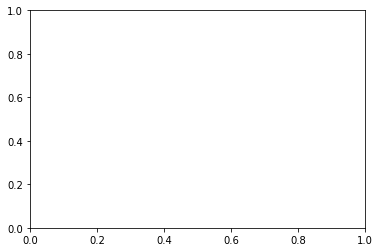

In [7]:
# some test distribution densities
n = 100
lam = 1e-3
x = torch.linspace(0, 100, n)
mu1 = torch.distributions.Normal(20., 10.).log_prob(x).exp()
mu2 = torch.distributions.Normal(60., 30.).log_prob(x).exp()
mu3 = torch.distributions.Normal(40., 20.).log_prob(x).exp()
mu1 /= mu1.sum()
mu2 /= mu2.sum()
mu3 /= mu3.sum()
mu123 = torch.stack([mu1, mu2, mu3], dim=0)
mu231 = torch.stack([mu2, mu3, mu1], dim=0)
cost = (x[None, :]-x[:, None])**2
cost /= cost.max()
pyplot.plot(mu1, label="$\mu_1$")
pyplot.plot(mu2, label="$\mu_2$")
pyplot.plot(mu3, label="$\mu_3$")
pyplot.legend();

We run a sanity check for the distance:
(This will take longer than you might expect, as it computes a rather large gradient numerically, but it finishes in $<1$ minute on a GTX 1080)

In [8]:
t = time.time()
device = "cuda"
res = torch.autograd.gradcheck(lambda x: SinkhornOT.apply(x.softmax(1), 
                                                    mu231.to(device=device, dtype=torch.double),
                                                    cost.to(device=device, dtype=torch.double),
                                                    lam, 500),
                         (mu123.log().to(device=device, dtype=torch.double).requires_grad_(),))
print("OK? {} took {:.0f} sec".format(res, time.time()-t))

NameError: name 'sinkstep' is not defined

We can visiualize the coupling along with the marginals:

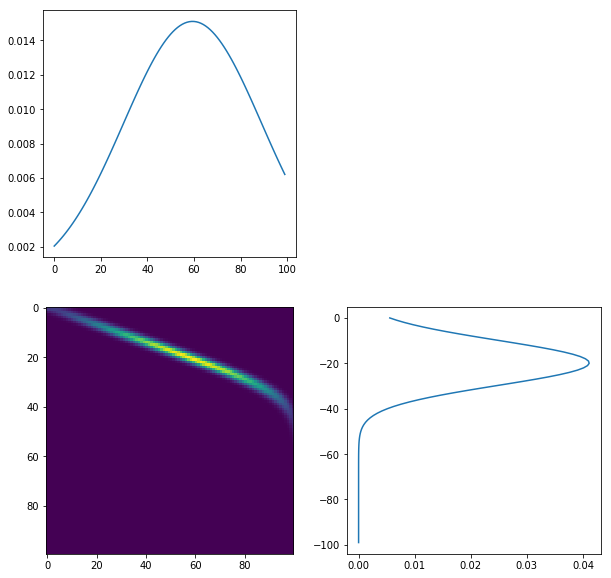

In [8]:
coupling = get_coupling(mu123.cuda(), mu231.cuda(), cost.cuda())
pyplot.figure(figsize=(10,10))
pyplot.subplot(2, 2, 1)
pyplot.plot(mu2.cpu())
pyplot.subplot(2, 2, 4)
pyplot.plot(mu1.cpu(), transform=matplotlib.transforms.Affine2D().rotate_deg(270) + pyplot.gca().transData)
pyplot.subplot(2, 2, 3)
pyplot.imshow(coupling[0].cpu());

This looks a lot like the coupling form Python Optimal Transport and in fact all three match results computed with POT:

5.492940545082092e-06

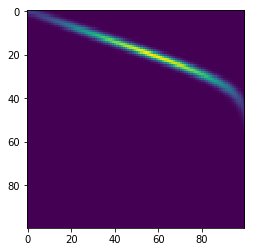

In [9]:
o_coupling12 = torch.tensor(ot.bregman.sinkhorn_stabilized(mu1.cpu(), mu2.cpu(), cost.cpu(), reg=1e-3))
o_coupling23 = torch.tensor(ot.bregman.sinkhorn_stabilized(mu2.cpu(), mu3.cpu(), cost.cpu(), reg=1e-3))
o_coupling31 = torch.tensor(ot.bregman.sinkhorn_stabilized(mu3.cpu(), mu1.cpu(), cost.cpu(), reg=1e-3))
pyplot.imshow(o_coupling12)
o_coupling = torch.stack([o_coupling12, o_coupling23, o_coupling31], dim=0)
(o_coupling.float() - coupling.cpu()).abs().max().item()

## Performance comparison to existing implementations

We copy the code of Dazac's recent [blog post](https://github.com/dfdazac/wassdistance/) in order to compare performance.

Dazac uses early stopping, but this comes at the cost of introducing a synchronization point after each iteration. I modified the code to take the distance matrix as an argument.

10 loops, best of 5: 46.7 ms per loop


68

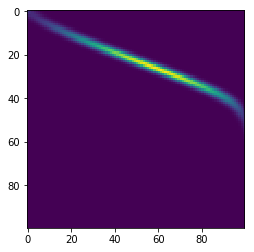

In [10]:
# Copyright 2018 Daniel Dazac
# MIT Licensed
# License and source: https://github.com/dfdazac/wassdistance/
class SinkhornDistance(torch.nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, mu, nu, C):
        u = torch.zeros_like(mu)
        v = torch.zeros_like(nu)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))
        self.actual_nits = actual_nits
        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

        return cost, pi, C

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

n = 100
x = torch.linspace(0, 100, n)
mu1 = torch.distributions.Normal(20., 10.).log_prob(x).exp()
mu2 = torch.distributions.Normal(60., 30.).log_prob(x).exp()
mu1 /= mu1.sum()
mu2 /= mu2.sum()
mu1, mu2, cost = mu1.cuda(), mu2.cuda(), cost.cuda()
sinkhorn = SinkhornDistance(eps=1e-3, max_iter=200)
def x():
    mu1_ = mu1.detach().requires_grad_()
    dist, P, C = sinkhorn(mu1_, mu2, cost)
    gr, = torch.autograd.grad(dist, mu1_)
    torch.cuda.synchronize()

dist, P, C = sinkhorn(mu1.cuda(), mu2.cuda(), cost.cuda())
torch.cuda.synchronize()
x()
%timeit x()
pyplot.imshow(P.cpu())
sinkhorn.actual_nits


In [11]:
def y():
    mu1_ = mu1.detach().requires_grad_()
    l = SinkhornOT.apply(mu1_.unsqueeze(0), mu2.unsqueeze(0), cost, 1e-3, 200)
    gr, = torch.autograd.grad(l.sum(), mu1_)
    torch.cuda.synchronize()
y()
%timeit y()

100 loops, best of 5: 6.47 ms per loop


With this problem size and forward + backward, we achieve a speedup factor of approximately 6.5 when doing about 3 times as many iterations.

## Barycenters

We can also do barycenters. Let's go 2d to do so. I use relative small $N$ because at the time of writing, my GPU is partially occupied by a long-running training.

tensor([0.0143], device='cuda:0')

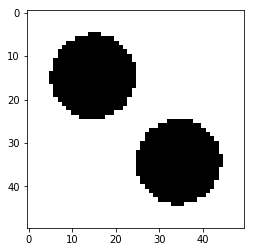

In [12]:
N = 50
a, b, c = torch.zeros(3, N, N, device="cuda")
x = torch.linspace(-5, 5, N, device="cuda")
a[N//5:-N//5, N//5:-N//5] = 1
b[(x[None]**2+x[:,None]**2 > 4) & (x[None]**2+x[:,None]**2 < 9)] = 1
c[((x[None]-2)**2+(x[:,None]-2)**2 < 4) | ((x[None]+2)**2+(x[:,None]+2)**2 < 4)] = 1
pyplot.imshow(c.cpu(), cmap=pyplot.cm.gray_r)
coords = torch.stack([x[None, :].expand(N, N), x[:, None].expand(N, N)], 2).view(-1, 2)
dist = ((coords[None]-coords[:, None])**2).sum(-1)
dist /= dist.max()
a = (a / a.sum()).view(1, -1)
b = (c / b.sum()).view(1, -1)
c = (c / c.sum()).view(1, -1)
SinkhornOT.apply(a, b, dist, 1e-3, 200)


In [13]:
def get_barycenter(mu, dist, weights, lam=1e-3, N=1000):
    assert mu.dim() == 2 and dist.dim() == 2 and weights.dim() == 1
    bs = mu.size(0)
    d1, d2 = dist.size()
    assert mu.size(1) == d1 and d1 == d2 and weights.size(0) == bs
    log_mu = mu.log()
    log_u = torch.full_like(mu, -math.log(d1))
    zeros = torch.zeros_like(log_u)
    for i in range(N):
        log_v = sinkstep(dist.t(), log_mu, log_u, lam)
        log_u = sinkstep(dist, zeros, log_v, lam)
        a = torch.sum(-weights[:, None] * log_u, dim=0, keepdim=True)
        log_u += a
    return (log_v[:, None, :]-dist/lam+log_u[:, :, None]).exp()


It's fast enough to just use baricenters for interpolation:

In [14]:
res = []
for i in torch.linspace(0, 1, 10):
    res.append(get_barycenter(torch.cat([a, b, c], 0), dist, torch.tensor([i*0.9, (1-i)*0.9, 0], device="cuda"), N=100))

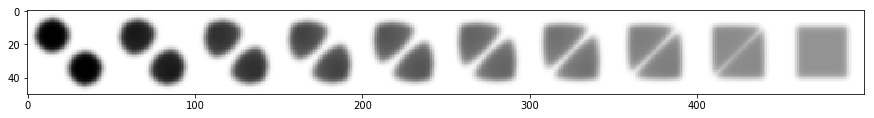

In [15]:
pyplot.figure(figsize=(15,5))
pyplot.imshow(torch.cat([r[0].sum(1).view(N, N).cpu() for r in res], 1), cmap=pyplot.cm.gray_r)